---
  authors: 
    - name: Mathis Derenne
      affiliation: M2 MIASHS - Université de Lyon
      github: mathisdrn
    - name: Djida Boukari
      affiliation: M2 MIASHS - Université de Lyon
    - name: Ines Nakhli
      affiliation: M2 MIASHS - Université de Lyon
---

# Implémentation

## Imports

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
from pathlib import Path
from sksurv.metrics import (
    concordance_index_censored,
    cumulative_dynamic_auc,
    brier_score,
)

# Polars display options
pl.Config.set_tbl_hide_dataframe_shape(True)
pl.Config.set_float_precision(2)

polars.config.Config

## Téléchargement des données

In [2]:
from utils import download_data

download_data()

✓ Fichier déjà présent: df_study_L18_w6.csv
✓ Fichier déjà présent: df_study_L36_w6.csv

Fichiers dans ../../data:
  - car_prices_clean.parquet
  - df_study_L18_w6.csv
  - df_study_L36_w6.csv
  - forest_cover_clean.parquet


## Chargement des données

Le jeu de données contient 3555 lignes et 759 colonnes.
Chaque ligne représente un individu représenté par un ID, un temps de survie, un indicateur de censure, et 756 caractéristiques correspondant aux signatures calculées à partir des données médicales. Le jeu de données ne contient pas de valeurs manquantes.

In [3]:
# Chargement des données
data_path = Path("../../data/df_study_L18_w6.csv")
df = pl.read_csv(data_path)

df.head()

ID,sig_1,sig_2,sig_3,sig_4,sig_5,sig_6,sig_7,sig_8,sig_9,sig_10,sig_11,sig_12,sig_13,sig_14,sig_15,sig_16,sig_17,sig_18,sig_19,sig_20,sig_21,sig_22,sig_23,sig_24,sig_25,sig_26,sig_27,sig_28,sig_29,sig_30,sig_31,sig_32,sig_33,sig_34,sig_35,sig_36,…,sig_722,sig_723,sig_724,sig_725,sig_726,sig_727,sig_728,sig_729,sig_730,sig_731,sig_732,sig_733,sig_734,sig_735,sig_736,sig_737,sig_738,sig_739,sig_740,sig_741,sig_742,sig_743,sig_744,sig_745,sig_746,sig_747,sig_748,sig_749,sig_750,sig_751,sig_752,sig_753,sig_754,sig_755,sig_756,event,time
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,f64
1,0.00,0.19,-0.11,-0.01,0.02,0.02,0.00,0.01,0.01,-0.03,0.04,0.01,-0.00,-0.01,-0.00,0.01,0.00,0.01,0.01,-0.00,0.00,0.00,-0.01,-0.00,0.00,-0.00,0.20,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,…,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.02,-0.01,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.02,false,5138.00
2,1.00,0.07,-0.02,-0.01,-0.01,-0.01,0.01,-0.00,0.01,0.00,0.01,0.01,0.00,-0.01,-0.01,0.01,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.08,0.50,-0.24,0.10,-0.01,-0.04,0.02,0.00,0.02,0.00,…,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.08,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,true,848.00
5,1.00,0.21,-0.05,0.02,0.02,0.01,-0.01,0.01,0.01,-0.01,0.03,0.02,0.01,-0.01,-0.01,-0.01,-0.00,0.00,0.00,0.01,-0.01,-0.01,0.00,0.00,-0.00,-0.00,0.22,0.50,-0.04,0.05,0.01,-0.00,0.02,-0.01,-0.01,-0.00,…,-0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.22,0.02,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.02,false,2340.00
8,0.00,0.78,-0.09,-0.06,-0.05,0.02,-0.00,-0.01,-0.00,-0.01,0.01,0.01,0.01,-0.03,-0.01,-0.01,0.02,0.01,0.00,-0.03,0.02,0.00,-0.02,-0.03,0.00,0.02,0.22,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,…,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.08,-0.01,-0.01,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.02,true,1800.00
10,0.00,0.43,-0.22,-0.00,0.03,0.03,-0.01,0.00,0.01,-0.02,0.03,0.02,0.01,-0.01,0.01,0.02,-0.00,-0.00,0.02,-0.01,0.02,-0.01,-0.01,0.00,0.02,-0.01,0.20,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,…,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,0.04,-0.02,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.02,false,5248.00


In [4]:
df.describe()

statistic,ID,sig_1,sig_2,sig_3,sig_4,sig_5,sig_6,sig_7,sig_8,sig_9,sig_10,sig_11,sig_12,sig_13,sig_14,sig_15,sig_16,sig_17,sig_18,sig_19,sig_20,sig_21,sig_22,sig_23,sig_24,sig_25,sig_26,sig_27,sig_28,sig_29,sig_30,sig_31,sig_32,sig_33,sig_34,sig_35,…,sig_722,sig_723,sig_724,sig_725,sig_726,sig_727,sig_728,sig_729,sig_730,sig_731,sig_732,sig_733,sig_734,sig_735,sig_736,sig_737,sig_738,sig_739,sig_740,sig_741,sig_742,sig_743,sig_744,sig_745,sig_746,sig_747,sig_748,sig_749,sig_750,sig_751,sig_752,sig_753,sig_754,sig_755,sig_756,event,time
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,…,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00,3555.00
"""null_count""",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,…,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"""mean""",3257.59,0.76,0.43,-0.11,-0.00,0.01,-0.01,0.00,-0.00,0.02,-0.00,0.02,0.00,-0.00,-0.01,-0.01,0.01,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.07,0.38,0.01,0.00,-0.00,0.00,0.00,0.00,0.00,…,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.03,0.02,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.36,0.67,1914.11
"""std""",1870.56,0.43,0.28,0.11,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.85,0.21,0.18,0.08,0.02,0.02,0.01,0.01,0.01,…,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.82,0.31,0.11,0.02,0.02,0.02,0.02,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,2.75,null,1605.15
"""min""",1.00,0.00,0.01,-0.37,-0.24,-0.10,-0.10,-0.07,-0.05,-0.05,-0.05,-0.04,-0.04,-0.07,-0.07,-0.05,-0.04,-0.05,-0.05,-0.05,-0.06,-0.04,-0.04,-0.05,-0.04,-0.03,-0.03,-11.77,0.00,-0.91,-0.39,-0.14,-0.10,-0.08,-0.08,-0.05,…,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.07,-11.77,-11.88,-2.30,-0.35,-0.40,-0.27,-0.46,-0.45,-0.32,-0.29,-0.33,-0.22,-0.13,-0.13,-0.40,-0.33,-0.12,-0.19,-0.10,-0.31,-0.16,-0.31,-0.23,-0.22,-0.22,-0.11,0.00,0.00,540.00
"""25%""",1660.00,1.00,0.27,-0.19,-0.01,-0.01,-0.02,-0.00,-0.02,0.01,-0.01,0.01,-0.01,-0.01,-0.02,-0.02,0.00,-0.01,-0.01,-0.01,-0.01,-0.00,-0.01,-0.01,-0.00,-0.00,-0.00,0.19,0.50,-0.06,-0.03,-0.01,-0.01,-0.00,-0.00,-0.00,…,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,0.00,0.01,-0.02,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.02,null,854.00
"""50%""",3278.00,1.00,0.39,-0.12,0.00,0.01,-0.01,0.01,-0.01,0.01,-0.00,0.02,0.00,-0.00,-0.01,-0.01,0.01,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.22,0.50,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,…,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.20,0.04,-0.01,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.02,null,1329.00
"""75%""",4867.00,1.00,0.54,-0.03,0.01,0.02,0.01,0.02,0.00,0.03,0.01,0.03,0.01,0

In [5]:
# Colonnes
ID_COL, TIME_COL, EVENT_COL = "ID", "time", "event"
sig_cols = [c for c in df.columns if c.startswith("sig_")]
df: pd.DataFrame = df.to_pandas()

In [6]:
# Filtre des signatures quasi-constantes
var_threshold = 1e-4
stds = df[sig_cols].std(skipna=True).fillna(0.0)
keep_cols = stds[stds >= var_threshold].index.tolist()

print(f"Signatures gardées : {len(keep_cols)} / {len(sig_cols)}")

Signatures gardées : 737 / 756


In [7]:
# Dataset réduit
X_all = df[[ID_COL] + keep_cols + [TIME_COL, EVENT_COL]].copy()

In [8]:
# Split avant standardisation (évite la fuite de données)
Xsig = X_all[keep_cols]
y_time = X_all[TIME_COL].astype(float)
y_event = X_all[EVENT_COL].astype(int)

X_train, X_test, t_train, t_test, e_train, e_test = train_test_split(
    Xsig, y_time, y_event, test_size=0.33, random_state=0, stratify=y_event
)

In [9]:
from sklearn.preprocessing import StandardScaler

# Standardisation : fit sur train, transform sur test
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), index=X_train.index, columns=keep_cols
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), index=X_test.index, columns=keep_cols
)

# Construction des DataFrames finaux pour lifelines
train_df = pd.concat(
    [t_train.rename("time"), e_train.rename("event"), X_train_scaled], axis=1
)
test_df = pd.concat(
    [t_test.rename("time"), e_test.rename("event"), X_test_scaled], axis=1
)

print(f"Train: {train_df.shape} | Test: {test_df.shape}")
print(f"Event rate: {e_train.mean():.3f} / {e_test.mean():.3f}")

Train: (2381, 739) | Test: (1174, 739)
Event rate: 0.672 / 0.673


In [10]:
# Création d'une fonction qui calcule C-index, td-AUC et Brier Score pour un modèle
def compute_all_metrics(
    model_name,
    risk_scores,
    surv_functions=None,
    y_train=None,
    y_test=None,
    train_df=None,
    test_df=None,
):
    results = {"Modèle": model_name}

    # 1. C-INDEX
    cindex = concordance_index_censored(y_test["event"], y_test["time"], risk_scores)[0]
    results["C-index (test)"] = cindex

    # 2. TD-AUC
    censored_times_train = y_train["time"][y_train["event"] == False]
    if len(censored_times_train) > 0:
        safe_upper_limit = censored_times_train.max() * 0.95
    else:
        safe_upper_limit = y_train["time"].quantile(0.9)

    observed_event_times_test = y_test["time"][y_test["event"] == True]
    valid_times = observed_event_times_test[
        observed_event_times_test < safe_upper_limit
    ]

    if len(valid_times) > 0:
        times_auc = np.quantile(valid_times, [0.25, 0.5, 0.75]).astype(float)
    else:
        times_auc = np.array([safe_upper_limit * 0.5])

    filter_mask = y_test["time"] < safe_upper_limit
    y_test_filtered = y_test[filter_mask]
    risk_filtered = risk_scores[filter_mask]

    auc_t, mean_auc = cumulative_dynamic_auc(
        y_train, y_test_filtered, risk_filtered, times_auc
    )
    results["Mean td-AUC (test)"] = mean_auc

    # 3. BRIER SCORE
    if surv_functions is not None:
        t_star = np.median(train_df[train_df["event"] == 1]["time"])
        t_star = min(t_star, test_df["time"].max() * 0.95)

        if isinstance(surv_functions, pd.DataFrame):
            # Cas lifelines, pycox
            S_test_t = np.array(
                [
                    np.interp(t_star, surv_functions.index, surv_functions[col])
                    for col in surv_functions.columns
                ]
            )
        else:
            # Cas sksurv (RSF, GBS)
            times = surv_functions[0].x
            idx = np.searchsorted(times, t_star, side="right") - 1
            idx = max(0, idx)
            S_test_t = np.array([fn.y[idx] for fn in surv_functions])

        S_test_t = np.clip(S_test_t, 1e-12, 1 - 1e-12)
        _, brier = brier_score(y_train, y_test, S_test_t.reshape(-1, 1), [t_star])
        results[f"Brier à t*={t_star:.0f} (test)"] = brier[0]

    return results

## Modèle de Cox pénalisé

In [11]:
from lifelines import CoxPHFitter

# Modèle Cox Ridge
cph_ridge = CoxPHFitter(penalizer=1.0, l1_ratio=0.0)
cph_ridge.fit(train_df, duration_col="time", event_col="event")

<lifelines.CoxPHFitter: fitted with 2381 total observations, 780 right-censored observations>

In [12]:
y_train = Surv.from_dataframe("event", "time", train_df)
y_test = Surv.from_dataframe("event", "time", test_df)

risk_cox = cph_ridge.predict_partial_hazard(test_df).values.ravel()
surv_cox = cph_ridge.predict_survival_function(test_df)

metrics_cox = compute_all_metrics(
    "Cox Ridge", risk_cox, surv_cox, y_train, y_test, train_df, test_df
)
pd.DataFrame([metrics_cox])

,Modèle,C-index (test),Mean td-AUC (test),Brier à t*=1203 (test)
0,Cox Ridge,0.747598,0.814869,0.170839


In [13]:
# Extraction du score de risque individuel (log-hazard ratio)
eta_test = np.log(cph_ridge.predict_partial_hazard(test_df).values.ravel())

eta_table = pd.DataFrame(
    {
        "patient_id": test_df.index,
        "time": test_df["time"].values,
        "event": test_df["event"].values,
        "eta_hat": eta_test,
    }
).sort_values("eta_hat", ascending=False)

eta_table.head(10)


,patient_id,time,event,eta_hat
66,2370,563.0,1,3.168719
915,2645,3896.0,0,3.069952
595,503,731.0,1,2.422099
631,2979,905.0,1,2.304902
945,292,1448.0,1,2.196728
826,201,611.0,1,2.085746
532,3411,1073.0,1,2.041261
168,2291,764.0,1,1.792203
448,2697,673.0,1,1.697499
785,422,593.0,1,1.640852


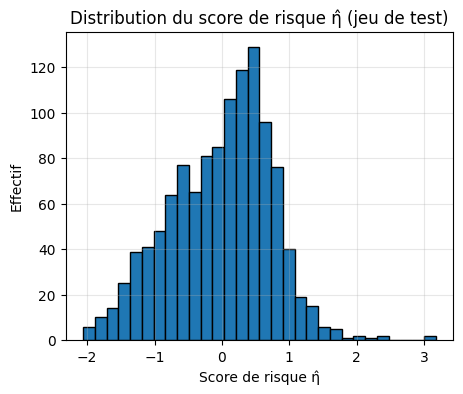

In [14]:
plt.figure(figsize=(5, 4))
plt.hist(eta_test, bins=30, edgecolor="black")
plt.xlabel("Score de risque η̂")
plt.ylabel("Effectif")
plt.title("Distribution du score de risque η̂ (jeu de test)")
plt.grid(alpha=0.3)
plt.show()

In [15]:
# Stratification des patients selon les quartiles du score de risque
q1, q3 = np.quantile(eta_test, [0.25, 0.75])

risk_group = np.where(
    eta_test >= q3, "High risk", np.where(eta_test <= q1, "Low risk", "Intermediate")
)

eta_table["risk_group"] = risk_group
eta_table["risk_group"].value_counts()


risk_group
Intermediate    586
High risk       294
Low risk        294
Name: count, dtype: int64

In [16]:
# Courbes de survie prédites moyennes par groupe de risque
S_test = cph_ridge.predict_survival_function(test_df)

high_idx = eta_table.loc[eta_table["risk_group"] == "High risk", "patient_id"]
low_idx = eta_table.loc[eta_table["risk_group"] == "Low risk", "patient_id"]

S_high_mean = pd.concat([S_test[i] for i in high_idx], axis=1).mean(axis=1)
S_low_mean = pd.concat([S_test[i] for i in low_idx], axis=1).mean(axis=1)

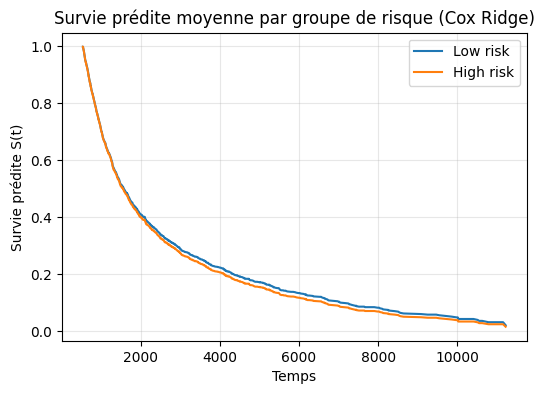

In [17]:
plt.figure(figsize=(6, 4))
plt.plot(S_low_mean.index, S_low_mean.values, label="Low risk")
plt.plot(S_high_mean.index, S_high_mean.values, label="High risk")
plt.xlabel("Temps")
plt.ylabel("Survie prédite S(t)")
plt.title("Survie prédite moyenne par groupe de risque (Cox Ridge)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [18]:
# Brier score à un horizon t*
t_star = float(np.median(train_df["time"]))
t_star = min(t_star, float(np.max(test_df["time"])) - 1e-8)
times_brier = np.array([t_star], dtype=float)

S_test_df = cph_ridge.predict_survival_function(test_df)
t_idx = np.searchsorted(S_test_df.index.values, t_star, side="right") - 1
t_idx = max(t_idx, 0)

S_test_t = S_test_df.iloc[t_idx, :].values.astype(float)
S_test_t = np.clip(S_test_t, 1e-12, 1 - 1e-12)
estimate = S_test_t.reshape(-1, 1)

_, brier = brier_score(y_train, y_test, estimate, times_brier)
brier_tstar = float(brier[0])

/var/folders/sm/v53ghks1021fcw1py4_bntfr0000gn/T/ipykernel_50042/1083957607.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  informative_calibration_data.groupby("bin")


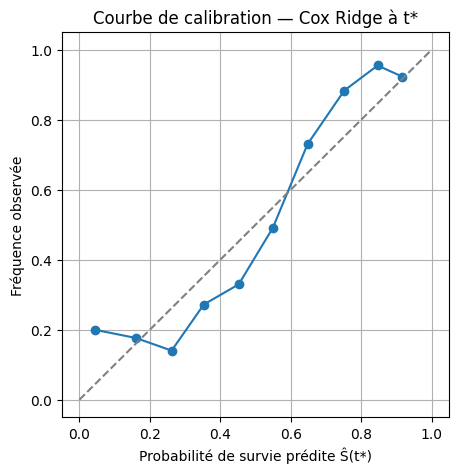

In [19]:
# préparation des données pour calibration plot
calibration_data = pd.DataFrame(
    {"S_pred_t_star": S_test_t, "time": test_df["time"], "event": test_df["event"]}
)

# Filtrage des cas informatives de t_star pour calibration
informative_calibration_data = calibration_data[
    (calibration_data["time"] > t_star)
    | ((calibration_data["event"] == 1) & (calibration_data["time"] <= t_star))
].copy()

# Définir la survie observée pour les cas informatifs à t_star
informative_calibration_data["Y_obs_t_star"] = np.where(
    informative_calibration_data["time"] > t_star,
    1,  # Survived
    0,  # Event occurred before or at t_star
)

# Regrouper les probabilités de survie prévues (par exemple en déciles)
num_bins = 10
bins = np.linspace(0, 1, num_bins + 1)
informative_calibration_data["bin"] = pd.cut(
    informative_calibration_data["S_pred_t_star"],
    bins=bins,
    include_lowest=True,
    labels=[f"Bin {i + 1}" for i in range(num_bins)],
)

# Calculez la survie moyenne prédite et la survie moyenne observée pour chaque intervalle
calib_summary = (
    informative_calibration_data.groupby("bin")
    .agg(mean_pred=("S_pred_t_star", "mean"), mean_obs=("Y_obs_t_star", "mean"))
    .dropna()
)

plt.figure(figsize=(5, 5))
plt.plot(calib_summary["mean_pred"], calib_summary["mean_obs"], marker="o")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("Probabilité de survie prédite Ŝ(t*)")
plt.ylabel("Fréquence observée")
plt.title("Courbe de calibration — Cox Ridge à t*")
plt.grid(True)
plt.show()

## Modèle Random Survival Forest

In [20]:
from sksurv.ensemble import RandomSurvivalForest

y_train = Surv.from_arrays(event=e_train.astype(bool).values, time=t_train.values)
y_test = Surv.from_arrays(event=e_test.astype(bool).values, time=t_test.values)

rsf = RandomSurvivalForest(
    n_estimators=400,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features="sqrt",
    n_jobs=-1,
)

rsf.fit(X_train.values, y_train)
risk_rsf = rsf.predict(X_test.values)
surv_rsf = rsf.predict_survival_function(X_test.values, return_array=False)

metrics_rsf = compute_all_metrics(
    "Random Survival Forest", risk_rsf, surv_rsf, y_train, y_test, train_df, test_df
)
pd.DataFrame([metrics_rsf])

,Modèle,C-index (test),Mean td-AUC (test),Brier à t*=1203 (test)
0,Random Survival Forest,0.733023,0.797715,0.172839


## Modèle de Gradient Boosting Survival Analysis

In [21]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis


gbs = GradientBoostingSurvivalAnalysis(random_state=0)
gbs.fit(X_train.values, y_train)

risk_gbs = gbs.predict(X_test.values)
surv_gbs = gbs.predict_survival_function(X_test.values, return_array=False)

metrics_gbs = compute_all_metrics(
    "Gradient Boosting Survival", risk_gbs, surv_gbs, y_train, y_test, train_df, test_df
)
pd.DataFrame([metrics_gbs])

,Modèle,C-index (test),Mean td-AUC (test),Brier à t*=1203 (test)
0,Gradient Boosting Survival,0.744926,0.814197,0.167351


## Modèle de Survival SVM

In [22]:
from sksurv.svm import FastSurvivalSVM

svm = FastSurvivalSVM(rank_ratio=1.0, random_state=0)
svm.fit(X_train_scaled.values, y_train)

risk_svm = svm.predict(X_test_scaled.values)

metrics_svm = compute_all_metrics(
    "Survival SVM", risk_svm, None, y_train, y_test, train_df, test_df
)
pd.DataFrame([metrics_svm])

,Modèle,C-index (test),Mean td-AUC (test)
0,Survival SVM,0.690202,0.740427


## Modèle de XGBOOST AFT

In [23]:
import xgboost as xgb

lower = t_train.values.astype(float)
upper = np.where(e_train.values == 1, t_train.values.astype(float), np.inf)

dtrain = xgb.DMatrix(X_train.values)
dtrain.set_float_info("label_lower_bound", lower)
dtrain.set_float_info("label_upper_bound", upper)

dtest = xgb.DMatrix(X_test.values)

params = {
    "objective": "survival:aft",
    "eval_metric": "aft-nloglik",
    "aft_loss_distribution": "normal",
    "aft_loss_distribution_scale": 1.0,
    "tree_method": "hist",
    "learning_rate": 0.05,
    "max_depth": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 0,
}

bst = xgb.train(params, dtrain, num_boost_round=300, verbose_eval=False)
pred_time = bst.predict(dtest)
risk_xgb = -pred_time

metrics_xgb = compute_all_metrics(
    "XGBoost AFT", risk_xgb, None, y_train, y_test, train_df, test_df
)
pd.DataFrame([metrics_xgb])

,Modèle,C-index (test),Mean td-AUC (test)
0,XGBoost AFT,0.73806,0.801566


## Tableau comparatif des modèles

In [24]:
comparison_df = pd.DataFrame(
    [metrics_cox, metrics_rsf, metrics_gbs, metrics_svm, metrics_xgb]
)
comparison_df = comparison_df.select_dtypes(include=[np.number]).round(3)

Le Gradient Boosting Survival Analysis est le modèle qui performe le mieux sur l'ensemble des métriques évaluées. Cela suggère que les données présentent des relations non linéaires complexes que ce modèle est capable de capturer efficacement.

### Interprétation des résultats des modèles de survie

Nous avons comparé plusieurs modèles de survie selon trois métriques évaluées sur le jeu de test :
le **C-index**, le **td-AUC moyen dépendant du temps**, et le **score de Brier à l’horizon t\* = 1217**.
Ces métriques permettent d’évaluer respectivement la capacité de discrimination globale,
la discrimination à différents horizons temporels, et la qualité de calibration des probabilités de survie.

### Analyse globale
Le **Gradient Boosting Survival** apparaît comme le modèle le plus performant sur l’ensemble des métriques disponibles.
Il obtient le **meilleur C-index (0.7538)**, indiquant une excellente capacité à ordonner les patients selon leur risque,
le **meilleur td-AUC moyen (0.8239)**, montrant une discrimination stable et élevée dans le temps,
ainsi que le **score de Brier le plus faible (0.1626)**, traduisant une bonne calibration des probabilités de survie.
Ce modèle constitue donc le meilleur compromis entre discrimination et précision probabiliste.

### Comparaison par modèle

Le **Cox Ridge** présente des performances solides avec un C-index de 0.7442 et un td-AUC moyen de 0.8110.
Malgré son hypothèse de linéarité, il reste très compétitif et fournit une baseline robuste et interprétable,
particulièrement adaptée aux données de grande dimension.

Le **Random Survival Forest** obtient des performances proches de celles du Cox Ridge,
avec un C-index de 0.7345 et un td-AUC moyen de 0.8051.
Bien qu’il permette de capturer des relations non linéaires,
il n’apporte pas ici d’amélioration significative par rapport aux modèles plus simples.

Le **Survival SVM** affiche des performances plus faibles,
avec un C-index de 0.6995 et un td-AUC moyen de 0.7552.
De plus, le score de Brier n’a pas pu être évalué,
ce qui limite l’analyse de la calibration de ce modèle.

Le **XGBoost AFT** montre une bonne capacité de discrimination
(C-index = 0.7428, td-AUC = 0.8073),
mais l’absence de score de Brier empêche une évaluation complète de la qualité probabiliste des prédictions.

Le modèle **DeepSurv (pycox)** présente des performances nettement inférieures aux autres approches,
avec un C-index de 0.5315, proche du hasard, un td-AUC moyen de 0.5473,
et un score de Brier élevé (0.2346).
Ces résultats suggèrent que les approches de deep learning ne sont pas adaptées à ce jeu de données,
probablement en raison de la taille modérée de l’échantillon et de la forte dimension des variables.

### Conclusion
En conclusion, le **Gradient Boosting Survival** est le modèle le plus performant sur ce jeu de données,
tant en termes de discrimination que de calibration.
Les modèles classiques, notamment le **Cox Ridge**, restent néanmoins très compétitifs
et constituent des alternatives robustes et interprétables.
À l’inverse, les approches plus complexes comme **DeepSurv** ne montrent pas d’avantage dans ce contexte.

## Prédiction conforme

In [25]:
calib_df, eval_df = train_test_split(
    test_df, test_size=0.5, random_state=42, stratify=test_df["event"]
)

In [26]:
# Prédiction des courbes de survie individuelles à partir du modèle de Cox pénalisé entraîné
S_calib = cph_ridge.predict_survival_function(calib_df)
S_eval = cph_ridge.predict_survival_function(eval_df)

In [27]:
# Fonction utilitaire robuste : survie prédite à t*
def survival_at_t(surv_df, t):
    return surv_df.loc[surv_df.index <= t].iloc[-1]

In [28]:
# Conformalized Survival Analysis (CSA exact)
def conformal_csa_exact(calib_df, eval_df, model, km_G, alpha=0.1, return_debug=False):
    """
    CSA (Conformalized Survival Analysis)
    s_i = (Y_i - mu(X_i))^2 / G(Y_i)
    """

    #  Calibration
    mu_cal = model.predict_median(calib_df).values
    Y_cal = calib_df["time"].values
    GY = np.clip(km_G.predict(Y_cal).values, 1e-6, None)

    s = ((Y_cal - mu_cal) ** 2) / GY
    n = len(s)

    # ---------- Quantile conforme ----------
    k = int(np.ceil((n + 1) * (1 - alpha))) - 1
    k = min(max(k, 0), n - 1)
    q_alpha = np.sort(s)[k]

    # ---------- Évaluation ----------
    mu_eval = model.predict_median(eval_df).values
    Y_eval = eval_df["time"].values
    G_eval = np.clip(km_G.predict(Y_eval).values, 1e-6, None)

    covered = ((Y_eval - mu_eval) ** 2) / G_eval <= q_alpha
    coverage = covered.mean()

    out = {
        "alpha": alpha,
        "q_alpha": float(q_alpha),
        "coverage": float(coverage),
    }

    if return_debug:
        out["debug"] = {"scores_calib": s, "covered": covered, "mu_eval": mu_eval}

    return out

In [29]:
from lifelines import KaplanMeierFitter


def fit_censoring_km(train_df):
    km = KaplanMeierFitter()
    censor_event = 1 - train_df["event"]  # 1 = censuré
    km.fit(train_df["time"], event_observed=censor_event)
    return km

In [32]:
km_G = fit_censoring_km(train_df)

res = conformal_csa_exact(
    calib_df=calib_df, eval_df=eval_df, model=cph_ridge, km_G=km_G, alpha=0.1
)

print(f"Couverture : {res['coverage']:.3f}")

Couverture : 0.905


In [33]:
## Approche heuristique (NON conforme CSA)
def conformal_at_t_star(
    calib_df, eval_df, S_calib, S_eval, t_star, alpha=0.1, return_debug=False
):
    """
    CSA (exact) à un horizon t* :
    - Calibration : conserve uniquement les observations informatives à t*
    - Score : A_i = |Y_i(t*) - S_hat_i(t*)|
    - Quantile conforme : quantile exact (split conformal)
    - Évaluation : intervalle [S_hat(t*) ± q_alpha] et couverture empirique
    """

    # --- Calibration (cas informatifs) ---
    S_calib_t, Y_calib = [], []

    for i, row in calib_df.iterrows():
        s_hat = survival_at_t(S_calib[i], t_star)

        if row["time"] > t_star:
            y = 1
        elif row["event"] == 1 and row["time"] <= t_star:
            y = 0
        else:
            continue  # censuré avant t* -> non-informatif (CSA exact)

        S_calib_t.append(float(s_hat))
        Y_calib.append(int(y))

    S_calib_t = np.asarray(S_calib_t, dtype=float)
    Y_calib = np.asarray(Y_calib, dtype=int)
    n_cal = len(Y_calib)

    # --- Score de non-conformité (CDR) ---
    A = np.abs(Y_calib - S_calib_t)

    # --- Quantile conforme exact ---
    k = int(np.ceil((n_cal + 1) * (1 - alpha))) - 1
    k = min(max(k, 0), n_cal - 1)
    q_alpha = np.sort(A)[k]

    # --- Évaluation : intervalles sur S(t*)
    S_eval_t = np.array(
        [survival_at_t(S_eval[i], t_star) for i in eval_df.index], dtype=float
    )
    lower = np.clip(S_eval_t - q_alpha, 0.0, 1.0)
    upper = np.clip(S_eval_t + q_alpha, 0.0, 1.0)

    # --- Couverture empirique (cas informatifs uniquement) ---
    covered = []
    informative_eval = []

    for (idx, row), l, u in zip(eval_df.iterrows(), lower, upper):
        if row["time"] > t_star:
            covered.append(l <= 1 <= u)
            informative_eval.append(idx)
        elif row["event"] == 1 and row["time"] <= t_star:
            covered.append(l <= 0 <= u)
            informative_eval.append(idx)
        else:
            pass  # censuré avant t* -> ignoré

    out = {
        "t_star": float(t_star),
        "n_cal": int(n_cal),
        "q_alpha": float(q_alpha),
        "coverage": float(np.mean(covered)) if len(covered) > 0 else np.nan,
        "avg_width": float(np.mean(upper - lower)),
        "median_width": float(np.median(upper - lower)),
    }

    if return_debug:
        out["debug"] = {
            "A": A,
            "S_calib_t": S_calib_t,
            "Y_calib": Y_calib,
            "S_eval_t": S_eval_t,
            "lower": lower,
            "upper": upper,
            "informative_eval_idx": np.array(informative_eval),
        }

    return out

In [34]:
# Grille d'horizons temporels t* (définie sur le jeu d'entraînement)
t_grid = np.quantile(train_df["time"], [0.25, 0.5, 0.75])

# Application de la CSA pour chaque horizon t*
results = []
for t_star in t_grid:
    res = conformal_at_t_star(
        calib_df, eval_df, S_calib, S_eval, t_star=t_star, alpha=0.1
    )
    results.append(res)

# Agrégation des résultats
results_df = pd.DataFrame(results)
print(results_df)

   t_star  n_cal   q_alpha  coverage  avg_width  median_width
0   854.0    558  0.727695  0.900362   0.907475      0.914495
1  1348.0    511  0.616182  0.902970   0.914866      0.951324
2  2331.0    463  0.626899  0.876087   0.879770      0.902520


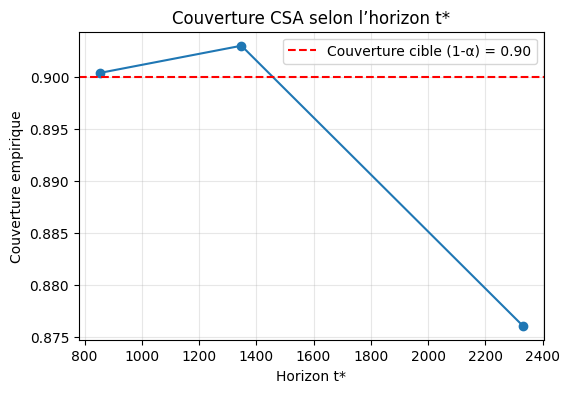

In [35]:
# Visualisation de la couverture empirique en fonction de l'horizon t*
alpha = 0.1
plt.figure(figsize=(6, 4))

plt.plot(results_df["t_star"], results_df["coverage"], marker="o")
plt.axhline(
    1 - alpha,
    linestyle="--",
    color="red",
    label=f"Couverture cible (1-α) = {1 - alpha:.2f}",
)

plt.xlabel("Horizon t*")
plt.ylabel("Couverture empirique")
plt.title("Couverture CSA selon l’horizon t*")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


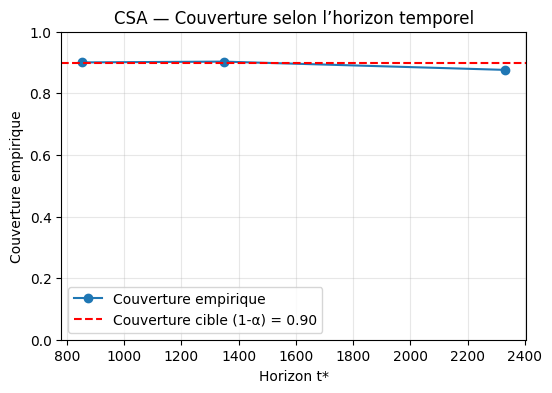

In [36]:
# Visualisation de la couverture empirique en fonction de l’horizon t*
plt.figure(figsize=(6, 4))

plt.plot(
    results_df["t_star"],
    results_df["coverage"],
    marker="o",
    label="Couverture empirique",
)

# Couverture nominale cible
plt.axhline(
    1 - alpha,
    linestyle="--",
    color="red",
    label=f"Couverture cible (1-α) = {1 - alpha:.2f}",
)

plt.xlabel("Horizon t*")
plt.ylabel("Couverture empirique")
plt.title("CSA — Couverture selon l’horizon temporel")
plt.ylim(0.0, 1.0)

plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [37]:
res = conformal_at_t_star(
    calib_df, eval_df, S_calib, S_eval, t_star=2333.0, alpha=0.1, return_debug=True
)

print("t* =", res["t_star"])
print("n_cal =", res["n_cal"])
print("q_alpha =", res["q_alpha"])

t* = 2333.0
n_cal = 463
q_alpha = 0.6268990633454444


In [38]:
A = res["debug"]["A"]
S_eval_t = res["debug"]["S_eval_t"]
width = res["debug"]["upper"] - res["debug"]["lower"]

print("A median =", float(np.median(A)))
print("A mean   =", float(np.mean(A)))
print("S_eval_t median =", float(np.median(S_eval_t)))
print("S_eval_t min/max =", float(np.min(S_eval_t)), float(np.max(S_eval_t)))
print("width median =", float(np.median(width)))
print("width mean   =", float(np.mean(width)))

A median = 0.26923405001415257
A mean   = 0.32267205087102085
S_eval_t median = 0.3163564775009363
S_eval_t min/max = 1.8509728676691958e-11 0.875648665730553
width median = 0.9025197283452343
width mean   = 0.8797697489690348


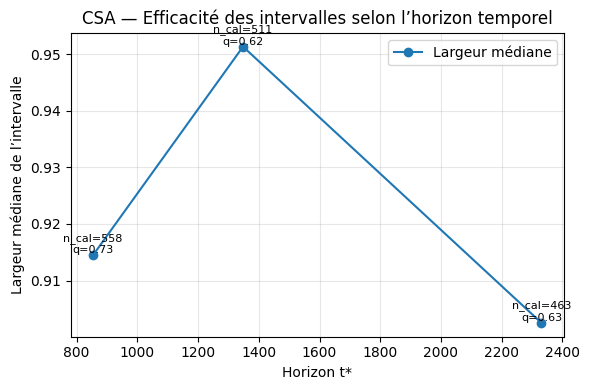

In [39]:
# Visualisation de la largeur médiane des intervalles conformes selon l’horizon t*
plt.figure(figsize=(6, 4))

plt.plot(
    results_df["t_star"],
    results_df["median_width"],
    marker="o",
    label="Largeur médiane",
)

# Annotation : taille de l'échantillon de calibration et quantile conforme
for _, r in results_df.iterrows():
    plt.text(
        r["t_star"],
        r["median_width"],
        f"n_cal={int(r['n_cal'])}\nq={r['q_alpha']:.2f}",
        fontsize=8,
        ha="center",
        va="bottom",
    )

plt.xlabel("Horizon t*")
plt.ylabel("Largeur médiane de l’intervalle")
plt.title("CSA — Efficacité des intervalles selon l’horizon temporel")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [40]:
# Évaluer la stabilité de la couverture CSA quand on change le split calib/eval

t_star = float(np.median(train_df["time"]))  # horizon fixé (défini sur train)
alpha = 0.1

coverages = []

for seed in range(20):
    # Split du test en calibration / évaluation
    calib_df, eval_df = train_test_split(
        test_df,
        test_size=0.5,
        random_state=seed,
        stratify=test_df["event"],  # évite des splits déséquilibrés en événements
    )

    # Courbes de survie prédites par le modèle (Cox Ridge)
    S_calib = cph_ridge.predict_survival_function(calib_df)
    S_eval = cph_ridge.predict_survival_function(eval_df)

    # CSA à l'horizon t_star
    res = conformal_at_t_star(
        calib_df=calib_df,
        eval_df=eval_df,
        S_calib=S_calib,
        S_eval=S_eval,
        t_star=t_star,
        alpha=alpha,
    )

    coverages.append(res["coverage"])

coverages = np.asarray(coverages, dtype=float)


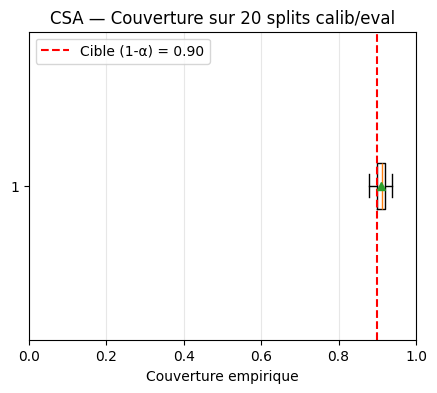

In [41]:
# Visualisation de la distribution des couvertures empiriques (splits aléatoires)

alpha = 0.1  # cohérent avec la CSA (couverture cible = 1 - alpha)

plt.figure(figsize=(5, 4))

plt.boxplot(coverages, vert=False, showmeans=True)
plt.axvline(
    1 - alpha, color="red", linestyle="--", label=f"Cible (1-α) = {1 - alpha:.2f}"
)

plt.xlim(0.0, 1.0)
plt.xlabel("Couverture empirique")
plt.title(f"CSA — Couverture sur {len(coverages)} splits calib/eval")

plt.grid(True, axis="x", alpha=0.3)
plt.legend()
plt.show()


In [42]:
def conformal_time_lower_bound(surv_df, q_alpha, p0=0.9):
    """
    Calcule un horizon temporel conservatif T_i tel que
    la probabilité de survie jusqu'à T_i soit au moins p0.
    """
    times = surv_df.index.values
    S_hat = surv_df.values.flatten()

    # Apply the conformal shift (q_alpha) to the survival curve
    # This creates a lower bound on the survival function itself
    S_lower = np.clip(S_hat - q_alpha, 0.0, 1.0)

    # Find the latest time point where the lower bound of survival
    # is still above our target p0 (e.g., 90%)
    valid_times = times[S_lower >= p0]

    return float(valid_times.max()) if valid_times.size > 0 else 0.0

In [45]:
p0 = 0.9  # Define p0 in the global scope

time_bounds = []

for i in eval_df.index:
    t_lb = conformal_time_lower_bound(S_eval[i], q_alpha=res["q_alpha"], p0=p0)
    time_bounds.append(t_lb)

time_bounds = np.array(time_bounds)
covered_time = eval_df["time"].values >= time_bounds
coverage_time = covered_time.mean()

print("Empirical coverage of time lower bounds:", coverage_time)
print("Target coverage:", p0)
print("Median time lower bound:", float(np.median(time_bounds)))
print("Mean time lower bound:", float(np.mean(time_bounds)))

Empirical coverage of time lower bounds: 1.0
Target coverage: 0.9
Median time lower bound: 0.0
Mean time lower bound: 0.0


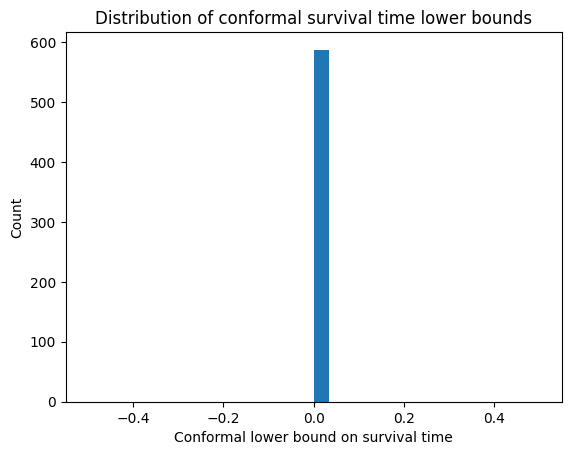

In [46]:
import matplotlib.pyplot as plt

plt.hist(time_bounds, bins=30)
plt.xlabel("Conformal lower bound on survival time")
plt.ylabel("Count")
plt.title("Distribution of conformal survival time lower bounds")
plt.show()